# **Identifying Key Entities in Recipe Data**


**Business Objective**:
The goal of this assignment is to train a Named Entity Recognition (NER) model using Conditional Random Fields (CRF) to extract key entities from recipe data. The model will classify words into predefined categories such as ingredients, quantities and units, enabling the creation of a structured database of recipes and ingredients that can be used to power advanced features in recipe management systems, dietary tracking apps, or e-commerce platforms.

### **Data Description**
The given data is in JSON format, representing a **structured recipe ingredient list** with **Named Entity Recognition (NER) labels**. Below is a breakdown of the data fields:

```json
[
    {
        "input": "6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil",
        "pos": "quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient"
    },
    {
      "input": "2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida",
      "pos": "quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient"
    }
]


| **Key**  | **Description**  |
|----------|-----------------|
| `input`  | Contains a raw ingredient list from a recipe. |
| `pos`    | Represents the corresponding part-of-speech (POS) tags or NER labels, identifying quantities, ingredients, and units. |


## **1** Import libraries

#### **1.1** Installation of sklearn-crfsuite

sklearn-crfsuite is a Python wrapper for CRFsuite, a fast and efficient implementation of Conditional Random Fields (CRFs). It is designed to integrate seamlessly with scikit-learn for structured prediction tasks such as Named Entity Recognition (NER), Part-of-Speech (POS) tagging, and chunking.

In [197]:
# installation of sklearn_crfsuite
!pip install sklearn_crfsuite==0.5.0


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


#### **1.2** Import necessary libraries

In [198]:
# Import warnings
import warnings
warnings.filterwarnings('ignore')

In [199]:
# Import necessary libraries
import json  # For handling JSON data
import pandas as pd  # For data manipulation and analysis
import re  # For regular expressions (useful for text preprocessing)
import matplotlib.pyplot as plt  # For visualisation
import seaborn as sns  # For advanced data visualisation
import sklearn_crfsuite  # CRF (Conditional Random Fields) implementation for sequence modeling
import numpy as np  # For numerical computations
# Saving and loading machine learning models
import joblib
import random
import spacy
from IPython.display import display, Markdown # For displaying well-formatted output

from fractions import Fraction  # For handling fractional values in numerical data
# Importing tools for feature engineering and model training
from collections import Counter  # For counting occurrences of elements in a list
from sklearn.model_selection import train_test_split  # For splitting dataset into train and test sets
from sklearn_crfsuite import metrics  # For evaluating CRF models
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
from sklearn.metrics import confusion_matrix

In [200]:
# Ensure pandas displays full content
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)

# Set themes, styles and color palette for seaborn charts
sns.set_theme(style='darkgrid', context='poster')
sns.set_palette(palette='pastel', n_colors=10)

plt.rcParams["figure.figsize"] = (12, 4)
plt.rcParams["axes.titlesize"] = 14 
plt.rcParams["axes.labelsize"] = 12 
plt.rcParams["xtick.labelsize"] = 10 
plt.rcParams["ytick.labelsize"] = 10 

## **2** Data Ingestion and Preparation <font color = red>[25 marks]</font> <br>

#### **2.1** *Read Recipe Data from Dataframe and prepare the data for analysis* <font color = red>[12 marks]</font> <br>
Read the data from JSON file, print first five rows and describe the dataframe

##### **2.1.1** **Define a *load_json_dataframe* function** <font color = red>[7 marks]</font> <br>

Define a function that takes path of the ingredient_and_quantity.json file and reads it, convert it into dataframe - df and return it.

In [201]:
# define a function to load json file to a dataframe
def load_json_dataframe(fpath):
    with open(fpath) as file:
        data = json.load(file)

    df = pd.DataFrame(data)

    return df

##### **2.1.2** **Execute the *load_json_dataframe* function** <font color = red>[2 marks]</font> <br>

In [202]:
# read the json file by giving the file path and create a dataframe
df = load_json_dataframe('ingredient_and_quantity.json')

##### **2.1.3** **Describe the dataframe** <font color = red>[3 marks]</font> <br>

Print first five rows of dataframe along with dimensions. Display the information of dataframe

In [203]:
# display first five rows of the dataframe - df
print(df.head())

                                                                                                                                                                                                                                                                                            input                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos
0                                                                                                 6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder D

In [204]:
# print the dimensions of dataframe - df
print(df.shape)

(285, 2)


In [205]:
# print the information of the dataframe
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285 entries, 0 to 284
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   input   285 non-null    object
 1   pos     285 non-null    object
dtypes: object(2)
memory usage: 4.6+ KB
None


#### **2.2** *Recipe Data Manipulation* <font color = red>[13 marks]</font> <br>
Create derived metrics in dataframe and provide insights of the dataframe

##### **2.2.1** **Create input_tokens and pos_tokens columns by splitting the input and pos from the dataframe** <font color = red>[3 marks]</font> <br>
Split the input and pos into input_tokens and pos_tokens in the dataframe and display it in the dataframe

In [206]:
# split the input and pos into input_tokens and pos_tokens in the dataframe

# Tokenize input
df['input_tokens'] = df['input'].str.split()

# Tokenize POS
df['pos_tokens'] = df['pos'].str.split()

In [207]:
# display first five rows of the dataframe - df
df.head()

,input,pos,input_tokens,pos_tokens
0,6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil,quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient,"[6, Karela, Bitter, Gourd, Pavakkai, Salt, 1, Onion, 3, tablespoon, Gram, flour, besan, 2, teaspoons, Turmeric, powder, Haldi, Red, Chilli, Cumin, seeds, Jeera, Coriander, Powder, Dhania, Amchur, Dry, Mango, Sunflower, Oil]","[quantity, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]"
1,2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida,quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient,"[2-1/2, cups, rice, cooked, 3, tomatoes, teaspoons, BC, Belle, Bhat, powder, 1, teaspoon, chickpea, lentils, 1/2, cumin, seeds, white, urad, dal, mustard, green, chilli, dry, red, 2, cashew, or, peanuts, 1-1/2, tablespoon, oil, asafoetida]","[quantity, unit, ingredient, ingredient, quantity, ingredient, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient]"
2,1-1/2 cups Rice Vermicelli Noodles Thin 1 Onion sliced 1/2 cup Carrots Gajjar chopped 1/3 Green peas Matar 2 Chillies 1/4 teaspoon Asafoetida hing Mustard seeds White Urad Dal Split Ghee sprig Curry leaves Salt Lemon juice,quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient,"[1-1/2, cups, Rice, Vermicelli, Noodles, Thin, 1, Onion, sliced, 1/2, cup, Carrots, Gajjar, chopped, 1/3, Green, peas, Matar, 2, Chillies, 1/4, teaspoon, Asafoetida, hing, Mustard, seeds, White, Urad, Dal, Split, Ghee, sprig, Curry, leaves, Salt, Lemon, juice]","[quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient]"
3,500 grams Chicken 2 Onion chopped 1 Tomato 4 Green Chillies slit inch Ginger finely 6 cloves Garlic 1/2 teaspoon Turmeric powder Haldi Garam masala tablespoon Sesame Gingelly Oil 1/4 Methi Seeds Fenugreek Coriander Dhania Dry Red Fennel seeds Saunf cups Sorrel Leaves Gongura picked and,quantity unit ingredient quantity ingredient ingredient quantity ingredient quantity ingredient ingredient ingredient unit ingredient ingredient qua

##### **2.2.2** **Provide the length for input_tokens and pos_tokens and validate their length** <font color = red>[2 marks]</font> <br>

Create input_length and pos_length columns in the dataframe and validate both the lengths. Check for the rows that are unequal in input and pos length


In [208]:
# create input_length and pos_length columns for the input_tokens and pos-tokens
df['input_length'] = df['input_tokens'].apply(len)
df['pos_length'] = df['pos_tokens'].apply(len)

In [209]:
# check for the equality of input_length and pos_length in the dataframe
unequal_rows = df[df['input_length'] != df['pos_length']]

In [210]:
unequal_rows[['input', 'pos', 'input_length', 'pos_length']]

,input,pos,input_length,pos_length
17,2 cups curd 1 cup gourd cucumber green cor coriander 1/2 teaspoon cumin powder salt,quantity unit ingredient quantity unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient,15,14
27,1 Baguette sliced 1 1/2 tablespoon Butter 1/2 Garlic minced cup Spinach Leaves Palak Red Bell pepper Capsicum Tomato finely chopped Onion Black powder Italian seasoning teaspoon Fresh cream Cheddar cheese grated Salt Roasted tomato pasta sauce,quantity ingredient ingredient quantity unit ingredient quantity ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient,37,36
79,1/2 cup Poha Flattened rice 2 tablespoons Rice flour 2 1/2 liter Milk 1 Nolen Gur or brown sugar Cardamom Elaichi Pods/Seeds 8-10 Mixed nuts almonds/cashews tablespoon Raisins pinch Saffron strands and a little more for garnish Salt,quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient quantity unit ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient unit ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient,38,37
164,1/2 cup All Purpose Flour Maida Whole Wheat 1/4 Hung Curd Greek Yogurt 250 grams Chicken minced 1 Spinach Leaves Palak finely chopped Onion 4 cloves Garlic Tomatoes tablespoon Cumin powder Jeera Coriander Powder Dhania 1 1/2 teaspoon Paprika Black pepper 3 sprig Mint Pudina 10 Spring Bulb & Greens 100 Feta Cheese crumbled,quantity unit ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient quantity unit ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient,54,53
207,1 cup Cashew nuts Badam Almond 1 1/4 cups Sugar 1/2 Water teaspoon Cardamom Powder Ghee for greasing,quantity unit ingredient ingredient ingredient ingredient quantity unit ingredient quantity ingredient unit ingredient ingredient ingredient unit ingredient,18,17


##### **2.2.3** **Define a unique_labels function and validate the labels in pos_tokens** <font color = red>[2 marks]</font> <br>

Define a unique_labels function which checks for all the unique pos labels in the recipe & execute it.


In [211]:
# Define a unique_labels function to checks for all the unique pos labels in the recipe & print it
def unique_labels(df):
    all_labels = [label for sublist in df['pos_tokens'] for label in sublist]

    return set(all_labels)

In [212]:
unique_pos_labels = unique_labels(df)

unique_pos_labels

{'ingredient', 'quantity', 'unit'}

##### **2.2.3** **Provide the insights seen in the recipe data after validation** <font color = red>[1 marks]</font> <br>

Provide the indexes that requires cleaning and formatting in the dataframe

In [213]:
unequal_rows.index.tolist()

[17, 27, 79, 164, 207]

<font color = red>5 rows have unequal input tokens and label lenths. All 5 rows have a difference of 1, which could possibly be because of spacing or missing labels</font> <br>


##### **2.2.4** **Drop the rows that have invalid data provided in previous cell** <font color = red> [2 marks]</font> <br>

In [214]:
# drop the irrelevant recipe data
df = df[df['input_length'] == df['pos_length']].reset_index(drop=True)

##### **2.2.5** **Update the input_length & pos_length in dataframe**<font color = red> [2 marks]</font> <br>

In [215]:
# update the input and pos length in input_length and pos_length
df['input_length'] = df['input_tokens'].apply(len)
df['pos_length'] = df['pos_tokens'].apply(len)

##### **2.2.6** **Validate the input_length and pos_length by checking unequal rows** <font color = red> [1 marks]</font> <br>

In [216]:
# validate the input length and pos length as input_length and pos_length
unequal_rows = df[df['input_length'] != df['pos_length']]
len(unequal_rows[['input', 'pos', 'input_length', 'pos_length']])

# Quick observation
#------------------
# There are no more rows with unequal tokens and pos labels
#------------------

0

## **3** Train Validation Split (70 train - 30 val) <font color = red>[6 marks]</font> <br>

#### **3.1** *Perform train and validation split ratio* <font color = red>[6 marks]</font> <br>
Split the dataset with the help of input_tokens and pos_tokens and make a ratio of 70:30 split for training and validation datasets.

###### **3.1.1** **Split the dataset into train_df and val_df into 70:30 ratio** <font color = red> [1 marks]</font> <br>

In [217]:
# split the dataset into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.3, random_state=100)

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

###### **3.1.2** **Print the first five rows of train_df and val_df** <font color = red> [1 marks]</font> <br>

In [218]:
# print the first five rows of train_df
train_df.head()

,input,pos,input_tokens,pos_tokens,input_length,pos_length
0,2 cups Rice 4 tablespoons Sunflower Oil 1 Onion chopped Tomato tablespoon Ginger Garlic Paste 1/4 teaspoon Red Chilli powder cup Carrots Gajjar Green peas Matar steamed Bell Pepper Capsicum Potato Aloo cut into small cubes Cardamom Elaichi Pods Seeds Cloves Laung Garam masala Star anise inch Cinnamon Stick Dalchini Coriander Dhania Leaves a bunch finely Mint Pudina few sprigs Salt,quantity unit ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient,"[2, cups, Rice, 4, tablespoons, Sunflower, Oil, 1, Onion, chopped, Tomato, tablespoon, Ginger, Garlic, Paste, 1/4, teaspoon, Red, Chilli, powder, cup, Carrots, Gajjar, Green, peas, Matar, steamed, Bell, Pepper, Capsicum, Potato, Aloo, cut, into, small, cubes, Cardamom, Elaichi, Pods, Seeds, Cloves, Laung, Garam, masala, Star, anise, inch, Cinnamon, Stick, Dalchini, Coriander, Dhania, Leaves, a, bunch, finely, Mint, Pudina, few, sprigs, Salt]","[quantity, unit, ingredient, quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]",61,61
1,400 grams Tindora Dondakaya Kovakkai 1 teaspoon Mustard seeds 1/2 White Urad Dal pinch Asafoetida hing sprig Curry leaves Dry Red Chilli tablespoon Sunflower Oil 2 tablespoons Coriander Dhania Seeds Chana dal Bengal Gram 4 Chillies 1/4,quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient quantity ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity,"[400, grams, Tindora, Dondakaya, Kovakkai, 1, teaspoon, Mustard, seeds, 1/2, White, Urad, Dal, pinch, Asafoetida, hing, sprig, Curry, leaves, Dry, Red, Chilli, tablespoon, Sunflower, Oil, 2, tablespoons, Coriander, Dhania, Seeds, Chana, dal, Bengal, Gram, 4, Chillies, 1/4]","[quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, quantity]",37,37
2,350 grams Paneer diced in cubes 1 pinch Asafoetida hing 2 inch Cinnamon Stick Dalchini Bay leaves tej patta 6 Cardamom Pods/Seeds 1/2 teaspoon Ajwain Carom seeds 3 Homemade tomato puree Kashmiri Red Chilli Powder Dry ginger powder 1/4 cup Curd Dahi Yogurt Fennel Saunf powdered Saffron strands Garam masala Salt sprig Coriander Dhania Leaves garnish,quantity unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity unit ingredient ingredient ingredient ingredie

In [219]:
# print the first five rows of the val_df
val_df.head()

,input,pos,input_tokens,pos_tokens,input_length,pos_length
0,2 cups rice cooked tomatoes finely chopped 1 onion thinly sliced teaspoon red chilli powder green slit mint leaves pudina fistful coriander dhania small bunch cinnamon stick dalchini cloves laung sprig curry tablespoon ghee salt inch ginger roughly 3 to 4 garlic fennel seeds saunf,quantity unit ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity ingredient ingredient ingredient ingredient,"[2, cups, rice, cooked, tomatoes, finely, chopped, 1, onion, thinly, sliced, teaspoon, red, chilli, powder, green, slit, mint, leaves, pudina, fistful, coriander, dhania, small, bunch, cinnamon, stick, dalchini, cloves, laung, sprig, curry, tablespoon, ghee, salt, inch, ginger, roughly, 3, to, 4, garlic, fennel, seeds, saunf]","[quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, quantity, ingredient, ingredient, ingredient, ingredient]",45,45
1,12 Baby Potatoes 1 Dry Red Chilli teaspoon Cumin seeds sprig Curry leaves Coriander Powder 1/2 Turmeric powder Garam masala Amchur Mango Lemon juice 3 tablespoons Leaves chopped,quantity ingredient ingredient quantity ingredient ingredient ingredient unit ingredient ingredient unit ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity unit ingredient ingredient,"[12, Baby, Potatoes, 1, Dry, Red, Chilli, teaspoon, Cumin, seeds, sprig, Curry, leaves, Coriander, Powder, 1/2, Turmeric, powder, Garam, masala, Amchur, Mango, Lemon, juice, 3, tablespoons, Leaves, chopped]","[quantity, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, unit, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient]",28,28
2,200 grams Jackfruit Raw Kathal 1 Onion sliced 4 cloves Garlic chopped inch Ginger tablespoon Cumin powder Jeera teaspoon Black pepper 1/2 Cinnamon Powder Dalchini 2 Paprika Turmeric Haldi cup Rajma Large Kidney Beans soaked boiled Tomato Red Chilli Sugar 1/4 Cooked rice Dried Thyme Leaves Bell Capsicum Yellow Pepper Green Sour cream Salsa Tortillas,quantity unit ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient unit ingredient unit ingredient ingredient ingredient unit ingredient ingredient quantity ingredient ingredient ingredient quantity ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient,"[200, grams, Jackfruit, Raw, Kathal, 1, Onion, sliced, 4, cloves, Garlic, chopped, inch, Ginger, tablespoon, Cumin, powder, Jeera, teaspoon, Black, pepper, 1/2, Cinnamon, Powder, Dalchini, 2, Paprika, Turmeric, Haldi, cup, Rajma, Large, Kidney, Beans, soaked, boiled, Tomato, Red, Chilli, Sugar, 1/4, Cooked, rice, Dried, Thyme, Leaves, Bell, Capsicum, Yellow, Pepper, Green, Sour, cream, Salsa, Tortillas]","[quantity, unit, ingredie

###### **3.1.3** **Extract the dataset into train_df and val_df into X_train, X_val, y_train and y_val and display their length** <font color = red> [2 marks]</font> <br>

Extract X_train, X_val, y_train and y_val by extracting the list of input_tokens and pos_tokens from train_df and val_df and also display their length

In [220]:
# extract the training and validation sets by taking input_tokens and pos_tokens
X_train = train_df['input_tokens'].tolist()
y_train = train_df['pos_tokens'].tolist()

X_val = val_df['input_tokens'].tolist()
y_val = val_df['pos_tokens'].tolist()

In [221]:
# validate the shape of training and validation samples
print(len(X_train))
print(len(y_train))
print(len(X_val))
print(len(y_val))

196
196
84
84


###### **3.1.4** **Display the number of unique labels present in y_train** <font color = red> [2 marks]</font> <br>

In [222]:
# Display the number of unique labels present in y_train
flat_labels = [label for seq in y_train for label in seq]

unique_labels_train = set(flat_labels)

print(len(unique_labels_train), unique_labels_train)

3 {'ingredient', 'quantity', 'unit'}


## **4** Exploratory Recipe Data Analysis on Training Dataset <font color = red>[16 marks]</font> <br>

#### **4.1** *Flatten the lists for input_tokens & pos_tokens* <font color = red>[2 marks]</font> <br>

Define a function **flatten_list** for flattening the structure for input_tokens and pos_tokens. The input parameter passed to this function is a nested list.

Initialise the dataset_name with a value ***'Training'***




In [223]:
# flatten the list for nested_list (input_tokens, pos_tokens)
def flatten_list (list):
    return [item for sublist in list for item in sublist]

In [224]:
# initialise the dataset_name
dataset_name = 'Training'

#### **4.2** *Extract and validate the tokens after using the flattening technique* <font color = red>[2 marks]</font> <br>

Define a function named ***extract_and_validate_tokens*** with parameters dataframe and dataset_name (Training/Validation), validate the length of input_tokens and pos_tokens from dataframe and display first 10 records for both the input_tokens and pos_tokens. Execute this function




In [225]:
# define a extract_and_validate_tokens with parameters (df, dataset_name)
# call the flatten_list and apply it on input_tokens and pos_tokens
# validate their length and display first 10 records having input and pos tokens
def extract_and_validate_tokens (df, dataset_name):
    flat_input_tokens = flatten_list (df['input_tokens'].tolist())
    flat_pos_tokens = flatten_list(df['pos_tokens'].tolist())

    if(len(flat_input_tokens) == len(flat_pos_tokens)):
        print('lengths are equal')
    else:
        print('lengths are not equal')

    print('First 10 tokens: ', flat_input_tokens[:10])
    print('First 10 POS tags: ', flat_pos_tokens[:10])

    return flat_input_tokens, flat_pos_tokens

In [226]:
# extract the tokens and its pos tags
flat_train_input, flat_train_pos = extract_and_validate_tokens(train_df, dataset_name)

lengths are equal
First 10 tokens:  ['2', 'cups', 'Rice', '4', 'tablespoons', 'Sunflower', 'Oil', '1', 'Onion', 'chopped']
First 10 POS tags:  ['quantity', 'unit', 'ingredient', 'quantity', 'unit', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'ingredient']


#### **4.3** *Categorise tokens into labels (unit, ingredient, quantity)* <font color = red>[2 marks]</font> <br>

Define a function ***categorize_tokens*** to categorise tokens into ingredients, units and quantities by using extracted tokens in the previous code and return a list of ingredients, units and quantities. Execute this function to get the list.



In [227]:
# define a categorize_tokens function and provide the tokens and pos_tags as parameters and create ingredient, unit and quantity list and return it
# validate the list that it comprised of these labels, if not return empty arrays
def categorize_tokens(tokens, pos_tags):
    ingredients = []
    units = []
    quantities = []

    for token, pos in zip(tokens, pos_tags):
        if pos == 'ingredient':
            ingredients.append(token)
        elif pos == 'unit':
            units.append(token)
        elif pos == 'quantity':
            quantities.append(token)

    return ingredients, units, quantities

In [228]:
#  call the function to categorise the labels into respective list
ingredients_list, units_list, quantities_list = categorize_tokens(flat_train_input, flat_train_pos)

print(ingredients_list[:10])
print(units_list[:10])
print(quantities_list[:10])

['Rice', 'Sunflower', 'Oil', 'Onion', 'chopped', 'Tomato', 'Ginger', 'Garlic', 'Paste', 'Red']
['cups', 'tablespoons', 'tablespoon', 'teaspoon', 'cup', 'inch', 'grams', 'teaspoon', 'sprig', 'tablespoon']
['2', '4', '1', '1/4', 'a', '400', '1', '1/2', 'pinch', '2']


#### **4.4** *Top 10 Most Frequent Items* <font color = red>[3 marks]</font> <br>

Define a function ***get_top_frequent_items*** to display top 10 most frequent items

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

Execute this function separately for top 10 most units and ingredients



In [229]:
# define a function get_top_frequent_items to get the top frequent items by using item_list, pos label and dataset_name(Training/Validation) and return top items
def get_top_frequent_items(item_list, pos_label, dataset_name, top_n=10):
    counter = Counter(item_list)
    top_items = counter.most_common(top_n)

    return top_items

In [230]:
# get the top ingredients which are frequently seen in the recipe
top_ingredients = get_top_frequent_items(ingredients_list, 'ingredient', dataset_name)

top_ingredients

[('powder', 125),
 ('Salt', 105),
 ('Oil', 84),
 ('seeds', 84),
 ('Red', 83),
 ('Chilli', 81),
 ('Green', 80),
 ('chopped', 71),
 ('Coriander', 65),
 ('Leaves', 61)]

In [231]:
# get the top units which are frequently seen in the recipe
top_units = get_top_frequent_items(units_list, 'unit', dataset_name) # , top_n=20

top_units

[('teaspoon', 153),
 ('cup', 131),
 ('tablespoon', 87),
 ('tablespoons', 69),
 ('grams', 56),
 ('cups', 55),
 ('inch', 48),
 ('sprig', 41),
 ('cloves', 39),
 ('teaspoons', 39)]

In [232]:
top_quantities = get_top_frequent_items(quantities_list, 'quantity', dataset_name) # , top_n=20

top_quantities

[('1', 186),
 ('2', 152),
 ('1/2', 142),
 ('1/4', 94),
 ('3', 65),
 ('4', 61),
 ('1-1/2', 24),
 ('5', 22),
 ('6', 17),
 ('200', 17)]

#### **4.5** *Plot Top 10 most frequent items* <font color = red>[2 marks]</font> <br>




Define a function ***plot_top_items*** to plot a bar graph on top 10 most frequent items for units and ingredients

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

In [233]:
# define plot top items with parameters - top_item list, label to suggest whether its ingredient or unit, dataset_name
def plot_top_items(top_items, label, dataset_name):
    items = []
    counts = []

    for pair in top_items:
        items.append(pair[0])
        counts.append(pair[1])

    sns.barplot(x=counts, y=items)
    plt.xlabel('Frequency')
    plt.ylabel(label.capitalize())
    plt.tight_layout()
    plt.show()

#### **4.6** *Perform EDA analysis* <font color = red>[5 marks]</font> <br>

Plot the bar plots for ingredients and units and provide the insights for training dataset

---



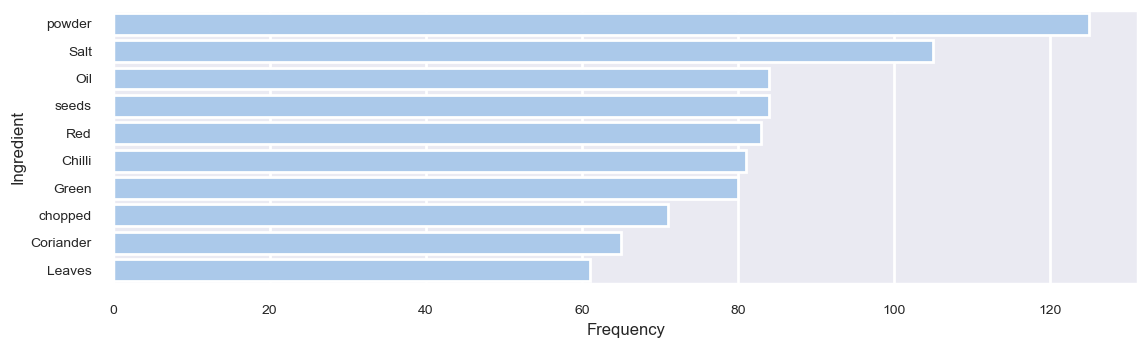

In [234]:
# plot the top frequent ingredients in training data
plot_top_items(top_ingredients, 'ingredient', dataset_name)

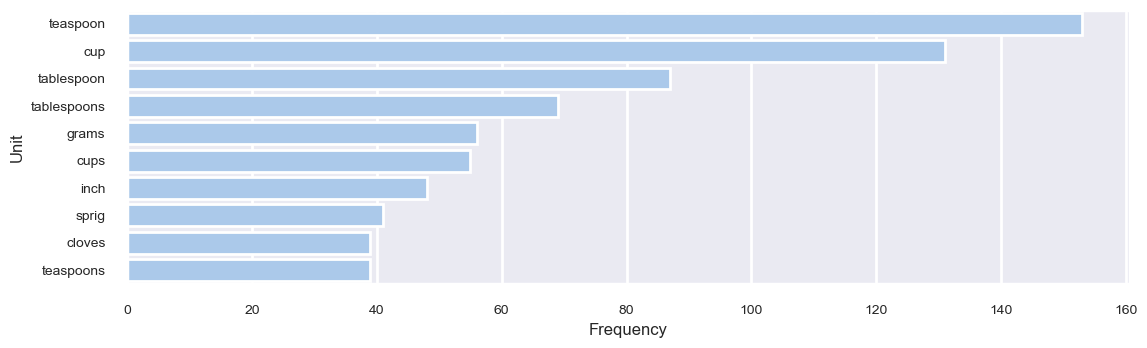

In [235]:
# plot the top frequent units in training data
plot_top_items(top_units, 'unit', dataset_name)

## **5** Exploratory Recipe Data Analysis on Validation Dataset (Optional)<font color = red> [0 marks]</font> <br>

#### **5.1** *Execute EDA on Validation Dataset with insights (Optional)* <font color = red> [0 marks]</font> <br>
Initialise the dataset_name as ***Validation*** and call the ***plot_top_items*** for top 10 ingredients and units in the recipe data
Provide the insights for the same.



In [236]:
# initialise the dataset_name


In [237]:
# use extract and validate tokens, categorise tokens, get top frequent items for ingredient list and unit list on validation dataframe


In [238]:
# plot the top frequent ingredients in validation data


In [239]:
# plot the top frequent units in training data


## **6** Feature Extraction For CRF Model <font color = red>[30 marks]</font> <br>

### **6.1** *Define a feature functions to take each token from recipe* <font color = red>[10 marks]</font>

Define a function as ***word2features*** which takes a particular recipe and its index to work with all recipe input tokens and include custom key-value pairs.

Also, use feature key-value pairs to mark the beginning and end of the sequence and to also check whether the word belongs to unit, quantity etc. Use keyword sets for unit and quantity for differentiating feature functions well. Also make use of relevant regex patterns on fractions, whole numbers etc.

##### **6.1.1** **Define keywords for unit and quantity and create a quantity pattern to work on fractions, numbers and decimals** <font color = red>[3 marks]</font> <br>

Create sets for **unit_keywords** and ***quantity_keywords*** and include all the words relevant for measuring the ingredients such as cup, tbsp, tsp etc. and in quantity keywords, include words such as half, quarter etc.

Also suggested to use regex pattern as ***quantity_pattern*** to work with quantity in any format such as fractions, numbers and decimals.

Then, load the spacy model and process the entire sentence

In [240]:
# define unit and quantity keywords along with quantity pattern
unit_keywords = {
    'teaspoon', 'teaspoons', 'cup', 'cups', 'tablespoon', 'tablespoons',
    'grams', 'kg', 'tsp', 'tbsp', 'inch', 'sprig', 'sprigs',
    'clove', 'cloves', 'pinch', 'stalks', 'stalk', 'spoon'
}

quantity_keywords = {
    '1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
    '1/2', '1/4', '3/4', '1-1/2', '1/3', 'a',
    '15', '50', '200', '250', '300', '500'
}

quantity_pattern = re.compile(r'^(\d+/\d+|\d+-\d+/\d+|\d+\.\d+|\d+|\d+[½¼¾⅓⅔]?)$')


In [241]:
# load spaCy model
nlp = spacy.load("en_core_web_sm")

##### **6.1.2** **Define feature functions for CRF** <font color = red>[7 marks]</font> <br>

Define ***word2features*** function and use the parameters such as sentence and its indexing as ***sent*** and ***i*** for extracting token level features for CRF Training.
Build ***features*** dictionary, also mark the beginning and end of the sequence and use the ***unit_keywords***, ***quantity_keywords*** and ***quantity_pattern*** for knowing the presence of quantity or unit in the tokens

While building ***features*** dictionary, include
- ***Core Features*** - The core features of a token should capture its lexical
and grammatical properties. Include attributes like the raw token, its lemma, part-of-speech tag, dependency relation, and shape, as well as indicators for whether it's a stop word, digit, or punctuation. The details of the features are given below:

    - `bias` - Constant feature with a fixed value of 1.0 to aid model learning.
    - `token` - The lowercase form of the current token.
    - `lemma` - The lowercase lemma (base form) of the token.
    - `pos_tag` - Part-of-speech (POS) tag of the token.
    - `tag` - Detailed POS tag of the token.
    - `dep` - Dependency relation of the token in the sentence.
    - `shape` - Shape of the token (e.g., "Xxx" for "Milk").
    - `is_stop` - Boolean indicating if the token is a stopword.
    - `is_digit` - Boolean indicating if the token consists of only digits.
    - `has_digit` - Boolean indicating if the token contains at least one digit.
    - `has_alpha` - Boolean indicating if the token contains at least one alphabetic character.
    - `hyphenated` - Boolean indicating if the token contains a hyphen (-).
    - `slash_present` - Boolean indicating if the token contains a slash (/).
    - `is_title` - Boolean indicating if the token starts with an uppercase letter.
    - `is_upper` - Boolean indicating if the token is fully uppercase.
    - `is_punct` - Boolean indicating if the token is a punctuation mark.

- ***Improved Quantity and Unit Detection*** - Use key-value pairs to mark the presence of quantities and units in the features dictionary. Utilise the unit_keywords, quantity_keywords, and quantity_pattern to identify and flag these elements. The details of the features are given below:

    - `is_quantity` - Boolean indicating if the token matches a quantity pattern or keyword.
    - `is_unit` - Boolean indicating if the token is a known measurement unit.
    - `is_numeric` - Boolean indicating if the token matches a numeric pattern.
    - `is_fraction` - Boolean indicating if the token represents a fraction (e.g., 1/2).
    - `is_decimal` - Boolean indicating if the token represents a decimal number (e.g., 3.14).
    - `preceding_word` - The previous token in the sentence, if available.
    - `following_word` - The next token in the sentence, if available.

- ***Contextual Features*** - Incorporate contextual information by adding features for the preceding and following tokens. Include indicators like BOS and EOS to mark the beginning and end of the sequence, and utilise unit_keywords, quantity_keywords, and quantity_pattern to identify the types of neighboring tokens. The features are given below:

    - `prev_token` - The lowercase form of the previous token.
    - `prev_is_quantity` - Boolean indicating if the previous token is a quantity.
    - `prev_is_digit` - Boolean indicating if the previous token is a digit.
    - `BOS` - Boolean indicating if the token is at the beginning of the sentence.
    - `next_token` - The lowercase form of the next token.
    - `next_is_unit` - Boolean indicating if the next token is a unit.
    - `next_is_ingredient` - Boolean indicating if the next token is not a unit or quantity.
    - `EOS` - Boolean indicating if the token is at the end of the sentence.



In [242]:
# define word2features for processing each token in the sentence sent by using index i.
# use your own feature functions

    # Process the entire sentence with spaCy

def word2features(sent, i):
    doc = nlp(' '.join(sent))
    token = doc[i]

    features = {
        # --- Core Features ---
        'bias': 1.0,
        'token': token.text.lower(),
        'lemma': token.lemma_.lower(),
        'pos_tag': token.pos_,
        'tag': token.tag_,
        'dep': token.dep_,
        'shape': token.shape_,
        'is_stop': token.is_stop,
        'is_digit': token.is_digit,
        'has_digit': any(char.isdigit() for char in token.text),
        'has_alpha': any(char.isalpha() for char in token.text),
        'hyphenated': '-' in token.text,
        'slash_present': '/' in token.text,
        'is_title': token.text.istitle(),
        'is_upper': token.text.isupper(),
        'is_punct': token.is_punct,

        # --- Improved Quantity & Unit Detection ---
        'is_quantity': token.text.lower() in quantity_keywords or bool(quantity_pattern.match(token.text)),
        'is_unit': token.text.lower() in unit_keywords,
        'is_numeric': token.like_num,
        'is_fraction': '/' in token.text and all(part.isdigit() for part in token.text.split('/') if part),
        'is_decimal': '.' in token.text and token.text.replace('.', '', 1).isdigit(),

        # Preceding and following words (if available)
        'preceding_word': sent[i-1].lower() if i > 0 else '',
        'following_word': sent[i+1].lower() if i < len(sent)-1 else '',

        # --- Contextual Features ---
        'BOS': i == 0,
        'EOS': i == len(sent) - 1
    }

    return features

### **6.2** *Preparation of Recipe level features* <font color = red>[2 marks]</font>


##### **6.2.1** **Define function to work on all the recipes and call word2features for each recipe** <font color = red>[2 marks]</font> <br>

Define ***sent2features*** function and inputs ***sent*** as a parameter and correctly generate feature functions for each token present in the sentence

In [243]:
# define sent2features by working on each token in the sentence and correctly generate dictionaries for features
def sent2features(sent):
    index_range = range(len(sent))
    return [word2features(sent, i) for i in index_range]

### **6.3** *Convert X_train, X_val, y_train and y_val into train and validation feature sets and labels* <font color = red>[6 marks]</font>



##### **6.3.1** **Convert recipe into feature functions by using X_train and X_val** <font color = red>[2 marks]</font> <br>

Create ***X_train_features*** and ***X_val_features*** as list to include the feature functions for each recipe present in training and validation sets

In [244]:
# Convert input sentences into feature sets by taking training and validation dataset as X_train_features and X_val_features
X_train_features = [sent2features(sent) for sent in X_train]
X_val_features = [sent2features(sent) for sent in X_val]

##### **6.3.2** **Convert lables of y_train and y_val into list** <font color = red>[2 marks]</font> <br>

Create ***y_train_labels*** and ***y_val_labels*** by using the list of y_train and y_val

In [245]:
# Convert labels into list as y_train_labels and y_val_labels
y_train_labels = [list(seq) for seq in y_train]
y_val_labels = [list(seq) for seq in y_val]

##### **6.3.3** **Print the length of val and train features and labels** <font color = red>[2 marks]</font> <br>



In [246]:
# print the length of train features and labels
print(len(X_train_features))
print(len(y_train_labels))

196
196


In [247]:
# print the length of validation features and labels
print(len(X_val_features))
print(len(y_val_labels))

84
84


### **6.4** *Applying weights to feature sets* <font color = red>[12 marks]</font> <br>




##### **6.4.1** **Flatten the labels of y_train** <font color = red>[2 marks]</font> <br>

Create ***y_train_flat*** to flatten the structure of nested y_train

In [248]:
# Flatten labels in y_train
y_train_flat = [label for sentence in y_train_labels for label in sentence]

##### **6.4.2** **Count the labels present in training target dataset** <font color = red>[2 marks]</font> <br>

Create ***label_counts*** to count the frequencies of labels present in y_train_flat and retrieve the total samples by using the values of label_counts as ***total_samples***

In [249]:
# Count label frequencies as label_counts and total_samples as getting the summation of values of label_counts
label_counts = Counter(y_train_flat)
total_samples = sum(label_counts.values())

print(label_counts, total_samples)

Counter({'ingredient': 5000, 'quantity': 959, 'unit': 813}) 6772


##### **6.4.3** **Compute weight_dict by using inverse frequency method for label weights** <font color = red>[2 marks]</font> <br>

- Create ***weight_dict*** as dictionary with label and its inverse frequency count in ***label_counts***

- Penalise ingredient label in the dictionary

In [253]:
# Compute class weights (inverse frequency method) by considering total_samples and label_counts
weights_dict = {}

for label in label_counts:
    weights_dict[label] = total_samples / label_counts[label]
    print(label, weights_dict[label])

quantity 7.061522419186653
unit 8.329643296432964
ingredient 1.3544


In [254]:
# penalise ingredient label
for weight in weights_dict:
    if weight == 'ingredient':
        weights_dict[weight] = weights_dict[weight] * 1.5
        
    print(weight, weights_dict[weight])

quantity 7.061522419186653
unit 8.329643296432964
ingredient 2.0316


##### **6.4.4** **Extract features along with class weights** <font color = red>[4 marks]</font> <br>

Define a function ***extract_features_with_class_weights*** to work with training and validation datasets and extract features by applying class weights





In [255]:
# Apply weights to feature extraction in extract_features_with_class_weights by using parameters such as X (input tokens), y(labels) and weight_dict (Class weights)
def extract_features_with_class_weights(X, y, weight_dict):
    X_weighted = []

    for i in range(len(X)):
        sentence_features = X[i]
        sentence_labels = y[i]

        sentence_weighted = []

        for j in range(len(sentence_features)):
            token_features = sentence_features[j]
            label = sentence_labels[j]

            token_features_with_weight = token_features.copy()

            if label in weight_dict:
                token_features_with_weight['weight'] = weight_dict[label]
            else:
                token_features_with_weight['weight'] = 1 # Assigning default valeu

            sentence_weighted.append(token_features_with_weight)

        X_weighted.append(sentence_weighted)

    return X_weighted

##### **6.4.5** **Execute extract_features_with_class_weights on training and validation datasets** <font color = red>[2 marks]</font> <br>

Create ***X_train_weighted_features*** and ***X_val_weighted_features*** for extracting training and validation features along with their weights by calling ***extract_features_with_class_weights*** on the datasets

In [273]:
# Apply manually computed class weights
X_train_weighted_features = extract_features_with_class_weights(X_train_features, y_train_labels, weights_dict)
X_val_weighted_features = extract_features_with_class_weights(X_val_features, y_val_labels, weights_dict)

print(X_train_weighted_features[0][0])

{'bias': 1.0, 'token': '2', 'lemma': '2', 'pos_tag': 'NUM', 'tag': 'CD', 'dep': 'nummod', 'shape': 'd', 'is_stop': False, 'is_digit': True, 'has_digit': True, 'has_alpha': False, 'hyphenated': False, 'slash_present': False, 'is_title': False, 'is_upper': False, 'is_punct': False, 'is_quantity': True, 'is_unit': False, 'is_numeric': True, 'is_fraction': False, 'is_decimal': False, 'preceding_word': '', 'following_word': 'cups', 'BOS': True, 'EOS': False, 'weight': 7.061522419186653}


## **7** Model Building and Training <font color = red>[10 marks]</font> <br>

### **7.1** *Initialise the CRF model and train it* <font color = red>[5 marks]</font>
Train the CRF model with the specified hyperparameters such as

### CRF Model Hyperparameters Explanation

| Parameter                  | Description |
|----------------------------|-------------|
| **algorithm='lbfgs'**      | Optimisation algorithm used for training. `lbfgs` (Limited-memory Broyden–Fletcher–Goldfarb–Shanno) is a quasi-Newton optimisation method. |
| **c1=0.5**                | L1 regularisation term to control sparsity in feature weights. Helps in feature selection. |
| **c2=1.0**                | L2 regularisation term to prevent overfitting by penalising large weights. |
| **max_iterations=100**     | Maximum number of iterations for model training. Higher values allow more convergence but increase computation time. |
| **all_possible_transitions=True** | Ensures that all possible state transitions are considered in training, making the model more robust. |

Use weight_dict for training CRF



In [274]:
# initialise CRF model with the specified hyperparameters and use weight_dict
crf_model = sklearn_crfsuite.CRF(algorithm='lbfgs', c1=0.5, c2=1.0, max_iterations=100, all_possible_transitions=True)

# train the CRF model with the weighted training data
crf_model.fit(X_train_weighted_features, y_train_labels)

,algorithm,'lbfgs'
,min_freq,None
,all_possible_states,None
,all_possible_transitions,True
,c1,0.5
,c2,1.0
,max_iterations,100
,num_memories,None
,epsilon,None
,period,None
,delta,None


### **7.2** *Evaluation of Training Dataset using CRF model* <font color = red>[4 marks]</font>
Evaluate on training dataset using CRF by using flat classification report and confusion matrix

In [275]:
# evaluate on the training dataset
y_train_pred = crf_model.predict(X_train_weighted_features)

In [ ]:
# specify the flat classification report by using training data for evaluation
print(flat_classification_report(y_train_labels, y_train_pred))

              precision    recall  f1-score   support

  ingredient       1.00      1.00      1.00      5000
    quantity       0.99      0.98      0.98       959
        unit       0.97      0.99      0.98       813

    accuracy                           0.99      6772
   macro avg       0.99      0.99      0.99      6772
weighted avg       1.00      0.99      0.99      6772



In [ ]:
# create a confusion matrix on training datset


### **7.3** *Save the CRF model* <font color = red>[1 marks]</font>
Save the CRF model

In [277]:
# dump the model using joblib as crf_model.pkl
joblib.dump(crf_model, 'crf_model.pkl')

['crf_model.pkl']

## **8** Prediction and Model Evaluation <font color = red>[3 marks]</font> <br>

### **8.1** *Predict and Evaluate the CRF model on validation set* <font color = red>[3 marks]</font>
Evaluate the metrics for CRF model by using flat classification report and confusion matrix




In [ ]:
# predict the crf model on validation dataset


In [ ]:
# specify flat classification report


In [ ]:
# create a confusion matrix on validation dataset


## **9** Error Analysis on Validation Data <font color = red>[10 marks]</font> <br>
Investigate misclassified samples in validation dataset and provide the insights


### **9.1** *Investigate misclassified samples in validation dataset* <font color = red>[8 marks]</font>



##### **9.1.1** Flatten the labels of validation data and initialise error data <font color = red>[2 marks]</font> <br>



Flatten the true and predicted labels and initialise the error data as ***error_data***

In [ ]:
# flatten Labels and Initialise Error Data


##### **9.1.2** Iterate the validation data and collect Error Information<font color = red> [2 marks]</font> <br>



Iterate through validation data (X_val, y_val_labels, y_pred_val) and compare true vs. predicted labels. Collect error details, including surrounding context, previous/next tokens, and class weights, then store them in error_data

In [ ]:
# iterate and collect Error Information

            # get previous and next tokens with handling for boundary cases


##### **9.1.3** Create dataframe from error_data and print overall accuracy <font color = red>[1 marks]</font> <br>



Change error_data into dataframe and then use it to illustrate the overall accuracy of validation data

In [ ]:
# Create DataFrame and Print Overall Accuracy


##### **9.1.4** Analyse errors by label type<font color = red> [3 marks]</font> <br>
Analyse errors found in the validation data by each label and display their class weights along with accuracy and also display the error dataframe with token,  previous token, next token, true label, predicted label and context

In [ ]:
# Analyse errors found in the validation data by each label
# and display their class weights along with accuracy
# and display the error dataframe with token, previous token, next token, true label, predicted label and context



### **9.2** *Provide insights from the validation dataset* <font color = red>[2 marks]</font>




 <font color = red>[Write your answer]</font>

## **10** Conclusion (Optional) <font color = red>[0 marks]</font> <br>

Write your findings and conclusion.